In [1]:
# https://keras.io/examples/vision/grad_cam/#setup
# https://dmitry.ai/t/topic/50/2
# Check Lambda Cloud

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

from keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import pandas as pd
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import decode_predictions
import numpy as np
import seaborn as sns
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

import warnings 
warnings.filterwarnings('ignore')

In [3]:
# Load model 
model = load_model('vgg16_01.h5')

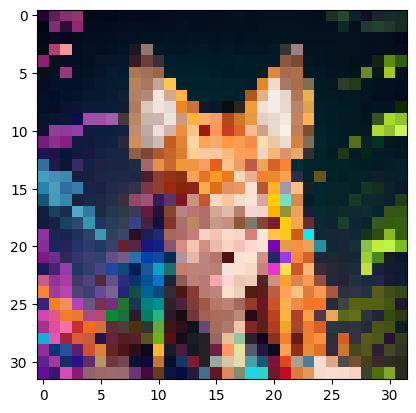

In [4]:
# Load img
img_path = r'aiimage.png'
img = image.load_img(img_path, target_size=(32, 32))
plt.imshow(img)

In [5]:
img = image.img_to_array(img)
img = preprocess_input(img, data_format=None)
img = img/255.0

img = np.expand_dims(img, axis=0)


In [10]:
img_pred = model.predict(img)
img_class = (img_pred > 0.5).astype(int)

img_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


array([[1]])